## Creation of the four PPS monomers

In [35]:
import mbuild as mb
import math
import gsd.hoomd
import numpy as np
import matplotlib.pyplot as plt

# Creates a mBuild compound of a single PPS monomer
pps = mb.load("c1ccc(S)cc1", smiles=True)

In [2]:
#Removes all of they hydogens from the simulation
pps.remove(pps.particles_by_element('H'))

In [3]:
system = mb.compound.Compound()

In [4]:
#Creats a box with four monomers inside of it
for i in range(4):
    clone = mb.clone(pps)
    if i %2 == 0:
        clone.rotate(theta = i*(math.pi/2), around = [0, 0, 1])
    else:
        clone.rotate(theta = i*(math.pi/2), around = [0, 1, 0])
    clone.translate([(i + 1), 1, 1])
    system.add(clone)
system.box = mb.Box([6, 2, 2])

In [5]:
#Todo:
#Make a function that takes a gsd file and calculates vectors of orientation for gay-berne major axis given the pps
# positions

In [6]:
#The system of four monomers of PPS
system.save("pps_box.gsd", overwrite=True)
#system.visualize()

/Users/noah/miniconda3/envs/try2/lib/python3.10/site-packages/gsd/hoomd.py:420: FutureWarning: Snapshot is deprecated, use Frame
  warnings.warn("Snapshot is deprecated, use Frame", FutureWarning)
/Users/noah/miniconda3/envs/try2/lib/python3.10/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'wb' mode is deprecated, use 'w'
  gsdfileobj = fl.open(name=str(name),


In [7]:
file = gsd.hoomd.open("pps_box.gsd", "r")

In [8]:
frame = file[0]

In [9]:
#frame.particles.position

## Getting the positions of the particles in one monomer

In [10]:
pps.save("one_pps.gsd", overwrite=True)

In [11]:
file = gsd.hoomd.open("one_pps.gsd", "r")
#Finds the real positions of the atoms in the monomer.
frame = file[0]
#partpos = particle position
partpos = frame.particles.position
#partmass = particle mass
partmass = frame.particles.mass

In [12]:
print(partpos)
len(partpos)
print(partmass)

[[-1.692836    0.01622056 -0.20739976]
 [-1.0209563  -1.2000172  -0.04773325]
 [ 0.35386935 -1.2118286   0.21015719]
 [ 1.0587134  -0.00560797  0.3083688 ]
 [ 2.8178067  -0.01955481  0.6384325 ]
 [ 0.38462818  1.2115655   0.14862752]
 [-0.99022084  1.2215596  -0.10921624]]
[12.011 12.011 12.011 12.011 32.06  12.011 12.011]


In [23]:
maxvect = None
maxdist = 0
greatdistindicies = None
for i, vect0 in enumerate(partpos):
    for j, vect1 in enumerate(partpos[i+1:]):
        vect = vect1 - vect0
        dist = np.linalg.norm(vect)
        if dist > maxdist:
            maxdist = dist
            maxvect = vect
            greatdistindicies = (i, j + i + 1)
print("The maximum distance of your monomer is", maxdist)
print("The vector that belongs to the maximum distance is", maxvect)

The maximum distance of your monomer is 4.589402
The vector that belongs to the maximum distance is [ 4.510643   -0.03577537  0.8458322 ]
(0, 4)


In [25]:
def find_major_axis(positions_arr):
    '''Finds the major axis for GB CG representation for use in axis-angle
    orientation representation.
    args:
        positions_arr: N_particlesx3 numpy array of particle positions to map to one aniso bead.
    returns:
        major_axis: numpy array designating vector of major axis of Gay-Berne particle
        particle_indicies: tuple of two particle indices used to calculate major axis vector
    '''
    major_axis = None
    max_dist = 0
    AB_indicies = (None, None)
    for i, x0 in enumerate(positions_arr):
        for j, x1 in enumerate(positions_arr[i+1:]):
            vect = x1 - x0
            dist = np.linalg.norm(vect)
            if dist > max_dist:
                max_dist = dist
                major_axis = vect
                # adjust j for loop stride
                AB_indicies = (i, j+i+1)
    return major_axis, AB_indicies

In [28]:
lpar, indicies = find_major_axis(partpos)
print(lpar)

[ 4.510643   -0.03577537  0.8458322 ]


In [15]:
#Finds the center of mass of the monomer
M = np.sum(partmass)
posCoMnumerator = partpos * np.reshape(partmass, [np.shape(partpos)[0], 1])
CoMcords = (np.sum(posCoMnumerator, axis = 0)) / M
print(CoMcords)

[ 0.6476411  -0.00234209  0.2314996 ]


In [18]:
def get_com(particle_positions, particle_masses):
    '''Calculate center of mass coordinates given a set of particle positions and masses.
    Positions and Masses arrays must be of same dimension.
    args:
        particle_positions: N_particlesx3 numpy array of particle positions (x,y,z)
        particle_masses: N_particlesx0 numpy array of particle masses
        
    returns:
        center_of_mass: 3x0 numpy array of center of mass coordinates'''
    
    M = np.sum(particle_masses)
    weighted_positions = particle_positions * particle_masses[:,np.newaxis]
    center_of_mass = np.sum(weighted_positions/M, axis=0)
    return center_of_mass

In [31]:
pps_center = get_com(partpos, partmass)

In [32]:
#Convert the vector along the major axis at the center of mass and convert that to quaternions
def find_minor_axis(particle_positions, center_of_mass):
    AB = maxvect
    CoM_vector = None
    maxdist = 0
    for i, vect0 in enumerate(partpos):
        if i in greatdistindicies:
            continue
        quatvect = vect0 - CoMcords
        dist = np.linalg.norm(quatvect)
        if dist > maxdist and not np.isclose(np.cross(AB, quatvect), np.zeros(3)).all():
            maxdist = dist
            CoM_vector = quatvect
    return CoM_vector

In [33]:
find_minor_axis(partpos, pps_center)

array([-1.637862  ,  1.2239017 , -0.34071583], dtype=float32)

In [170]:
def vect_3d_for_plotting(point, vector):
    """Makes xs, ys, zs, for plotting a vector from a given point in matplotlib"""
    vectnorm = np.linalg.norm(vector)
    xs = [point[0], point[0]+vector[0]]
    ys = [point[1], point[1]+vector[1]]
    zs = [point[2], point[2]+vector[2]]
    return xs, ys, zs

In [171]:
vect_3d_for_plotting(CoMcords, lpar)

([0.6476411, 5.158284], [-0.0023420916, -0.03811746], [0.2314996, 1.0773318])

In [172]:
CoM_vector = find_minor_axis(partpos, pps_center)

In [173]:
X = np.linspace(-2, 5, 50)
Y = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(X,Y)
#d = CoMcords[2] * n0[2]
d = np.dot(CoMcords, n0)
Z = (d - n0[0]*X - n0[1]*Y) / n0[2]

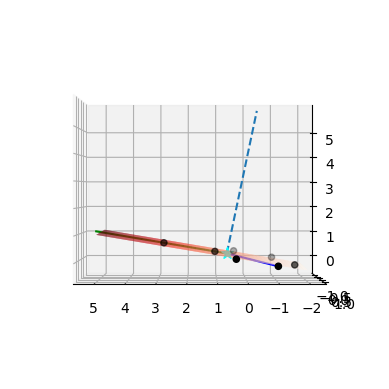

In [174]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(partpos[:,0], partpos[:,1], partpos[:,2], color = 'black')
ax.scatter(*CoMcords, marker = '*', s = 72, color = 'cyan')
ax.plot3D(*vect_3d_for_plotting(CoMcords, lpar), color = 'green')
ax.plot3D(*vect_3d_for_plotting(CoMcords, CoM_vector), color = 'blue')
ax.plot3D(*vect_3d_for_plotting(CoMcords, n0), ls = '--')
ax.plot_surface(X,Y,Z, cmap = matplotlib.cm.Reds)
ax.view_init(roll = 0, elev =0, azim = 90)

In [41]:
help(ax.view_init)

Help on method view_init in module mpl_toolkits.mplot3d.axes3d:

view_init(elev=None, azim=None, roll=None, vertical_axis='z') method of mpl_toolkits.mplot3d.axes3d.Axes3D instance
    Set the elevation and azimuth of the axes in degrees (not radians).
    
    This can be used to rotate the axes programmatically.
    
    To look normal to the primary planes, the following elevation and
    azimuth angles can be used. A roll angle of 0, 90, 180, or 270 deg
    will rotate these views while keeping the axes at right angles.
    
    ==========   ====  ====
    view plane   elev  azim
    ==========   ====  ====
    XY           90    -90
    XZ           0     -90
    YZ           0     0
    -XY          -90   90
    -XZ          0     90
    -YZ          0     180
    ==========   ====  ====
    
    Parameters
    ----------
    elev : float, default: None
        The elevation angle in degrees rotates the camera above the plane
        pierced by the vertical axis, with a positive 

In [ ]:
#I believe in order to do the math in the seperate cell we need to load in a new monomer, that way new values
# can be grabbed to get the rotation coordinates, which then can be turned into quaternions

In [167]:
#Need to define our plane and make an angle of rotation
#AB and CoMC are defined in the cell above, they serve as the orignal orientation

#Finds the information from the differently oriented monomer and produces the axis vector
#lpar1 = find_major_axis(positions_arr)
#ACoM1 = #What ever the name for the function above will be an it's arguments
n0 = np.cross(lpar, CoM_vector)
n1 = np.cross(lpar1, ACoM1)
V_axis = np.cross(n0, n1)

#Solving for the theta
theta_numerator = np.dot(n0, n1)
theta_denominator = np.linalg.norm(n0) * np.linalg.norm(n1)
theta_rotation = np.arccos(theta_numerator / theta_denominator)

#Taking in the axis vector and theta in order to turn the axis angle and theta orientations into zero
quaternions = rowan.from_axis_angle(V_axis, theta_rotation)

NameError: name 'lpar1' is not defined

In [ ]:
#distanceList = []
#vectorList = []
#vectorcompDist = []
#for i in range(len(partpos)):
#    x0 = partpos[i][0]
#    y0 = partpos[i][1]
#    z0 = partpos[i][2]
    #print(x0, y0, z0) 
#    for j in range(len(partpos)):
#        xd = x0 - partpos[j][0]
#        yd = y0 - partpos[j][1]
#        zd = z0 - partpos[j][2]
#        vectorList.append([xd, yd, zd])
#        dist = np.sqrt((xd**2)+(yd**2)+(zd**2))
#        distanceList.append(dist)
#        vectorcompDist.append([partpos[i], partpos[j], dist])
#maxdist = max(distanceList)
#print("The maximum distance of your monomer is", maxdist)
#maxvect = max(vectorList)
#print("The vector that belongs to the maximum distance is", maxvect)
#normvect = maxvect / np.linalg.norm(maxvect)
#print("The unit vector along the major axis is :", normvect)

#whichelementVmax = vectorList.index(maxvect)
#whichelementDmax = distanceList.index(maxdist)

#for k in range(len(vectorcompDist)):
#    if vectorcompDist[k][2] == maxdist:
#        print("Our component vectors and distance are as follows:", vectorcompDist[k])

In [ ]:
#Finds the center of mass of the monomer
#xi_mi_positions = []
#yi_mi_positions = []
#zi_mi_positions = []
#for i in range(len(partpos)):
#    xi_mi = partpos[i][0] * partmass[i]
#    yi_mi = partpos[i][1] * partmass[i]
#    zi_mi = partpos[i][2] * partmass[i]
#    xi_mi_positions.append(xi_mi)
#    yi_mi_positions.append(yi_mi)
#    zi_mi_positions.append(zi_mi)
#M = np.sum(partmass)
#x_CoM = (np.sum(xi_mi_positions)) / M
#y_CoM = (np.sum(yi_mi_positions)) / M
#z_CoM = (np.sum(zi_mi_positions)) / M
#CoMcords = np.array([x_CoM, y_CoM, z_CoM])
#print("The center of Mass of your monomer is",CoMcords)